In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.optimize as opt
import scipy.integrate as integrate
import sys
import scipy.stats
from iminuit import Minuit
import scipy.constants as scon

MassPerPart = 2.0975e+15 / 1.989e33 # solar masses

H = 1.8359e-18 # 1 / s
G = 6.672e-8 * (3.24078e-25)**3 * (1.989e-33)**(-1)
rhoc = 140.0e9#3 * H * H / (8 * np.pi * G) # M_sun / Mpc^3

"""
Functions used to load in the data and prepare the halos for analysis
""";
def load_data(PATH, time_step, num_files):
# loads in the data from the .particle and .ascii files and concatenates "num_files" of these files into arrays
# that can be read as the data from a single file
    for i in range(num_files):
        print('Loading File ' + str(i))
        if i == 0:
            particle_data=np.loadtxt(PATH + 'halos_' + str(time_step) + '.' +\
                                     str(i) + '.particles',
                                     dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data   =np.loadtxt(PATH + 'halos_' + str(time_step) + '.' + str(i) + '.ascii',
                                     dtype=float, delimiter=' ', comments='#')
        else:
            particle_data_new = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.particles',
                                           dtype=float, delimiter=' ', comments=['#', '&'])
            ascii_data_new    = np.loadtxt(PATH + 'halos_' + str(time_step) +\
                                           '.' + str(i) + '.ascii',
                                           dtype=float, delimiter=' ', comments='#')
            particle_data = np.concatenate((particle_data, particle_data_new), axis=0)
            ascii_data    = np.concatenate((ascii_data, ascii_data_new), axis=0)

    print("Data Loaded...")
    return particle_data, ascii_data;

"""
Functions used to calculate the halo density profile
""";
def parse_halos(ascii_data):
# gets the number of particles in each halo so that when you read in the particle data, you know when to 
# start and stop when looking at particles for a specific halo
    halo_nums = ascii_data[:, 1]
    halo_breaks = np.empty(np.size(halo_nums) + 1)
    for i in range(np.size(halo_breaks)):
        halo_breaks[i] = np.sum(halo_nums[:i])
    return halo_breaks;

def get_halo_position(particle_positions):
# gets the position of the halo by finding the center of mass of the halo assuming each
# particle has the same mass
    x = np.mean(particle_positions[:, 0])
    y = np.mean(particle_positions[:, 1])
    z = np.mean(particle_positions[:, 2])
    return np.array([x, y, z]);
    
def get_separations(particle_positions, halo_position):
# gets the radial separations of each particle from the center. This will allow for a calculation of the 
# radial density profile
    separations = np.zeros(np.shape(particle_positions)[0])
    for i in range(np.shape(particle_positions)[0]):
        separations[i] = np.linalg.norm(particle_positions[i, :] - halo_position)
    return separations;

def get_density_profile(particle_data, ascii_data, halo_breaks, halo_id, N):
# finds the density profile of the halo with id "halo_id". The density profile is a histogram of particles with N
# bins of radial separation.
    # get data for the halo you chose
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position  = get_halo_position(halo_particles)
    displacements  = get_separations(halo_particles, halo_position)
    if len(displacements) == 0:
        return np.zeros(N), np.zeros(N), 0.0, 0.0, 0.0;
    radius = np.max(displacements)
    half_mass_radius = ascii_data[halo_id, 48]
    
    fractions = np.linspace(0.22, 1.0, N)
    radial_fractions = fractions * radius 
    # gives an array of 10%, 20%, ..., 90%, 100% of the halo radius
    radial_counts = np.zeros(N)
    for i in range(0, N):
        counts = 0
        for j in range(len(displacements)):
            if displacements[j] <= radial_fractions[i]:
                counts += 1
        radial_counts[i] = counts
    density = radial_counts * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    std_density = np.sqrt(radial_counts) * MassPerPart / (4 * np.pi * radial_fractions**3 / 3)
    normalized_counts = radial_counts / len(displacements)
    
    return radial_fractions, density, radial_counts, radius, std_density;

def plot_density_profile(radial_fractions, density, radius, std_density):
# plots the density profile along with fits to the density profile to an nfw density profile
    ics_nfw = np.array([radius, np.mean(density)])
    popt_nfw, pcov_nfw = opt.curve_fit(model_nfw, radial_fractions,
                                       density, p0=ics_nfw, sigma=std_density)
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    nfw_fit = model_nfw(radial_fit, popt_nfw[0], popt_nfw[1])
    
    params = {'legend.fontsize': 14,
              'legend.shadow': False}
    plt.rcParams.update(params)
    plt.figure(figsize=(10,7))
    plt.errorbar(radial_fractions, density, fmt='o', yerr=std_density, label='Simulation')
    plt.plot(radial_fit, nfw_fit, '-', label='NFW Fit')
    plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
    plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
    plt.title(r'Radial Density Profile',
              fontsize=16, fontname='serif')
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
    plt.show()
    return;

"""
Functions used to fit halos to an NFW profile
""";
def get_largest_halos(ascii_data, num_sigma):
# finds all of the halos that have a total number of particles "num_sigma" standard deviations above the mean
# number of particles
    largest_halos = []
    for i in range(int(np.shape(ascii_data)[0])):
        if ascii_data[i, 1] >= np.mean(ascii_data[:, 1]) + num_sigma * np.std(ascii_data[:, 1]):
            largest_halos.append(i)
    return largest_halos;

def model_nfw(r, m200, c200):
# the model equation for an nfw profile
    r200 = (3 * m200 / (800 * np.pi * rhoc))**(1 / 3)
    t1 = 4 * np.pi * (np.log(1 + c200) - c200 / (1 + c200))
    t2 = r * (r200 / c200 + r)**2
    return m200 / (t1 * t2);

def get_mass(R, m200, c200):
    r200 = (3 * m200 / (800 * np.pi * rhoc))**(1 / 3)
    t1 = m200 / (np.log(1 + c200) - c200 / (1 + c200))
    t2 = (r200 / c200) / (r200 / c200 + R) + np.log(r200 / c200 + R)
    t3 = -1 - np.log(r200 / c200)
    return t1 * (t2 + t3);

def log_likelihood(m, c, obs_counts, obs_radii):
    exp_mass = get_mass(obs_radii, m, c)
    exp_counts = exp_mass / MassPerPart
    likelihood = 0
    for i in range(np.size(exp_counts)):
        #print(scipy.stats.poisson.logpmf(int(obs_counts[i]), exp_counts[i]))
        likelihood -= scipy.stats.poisson.logpmf(int(obs_counts[i]), exp_counts[i])
    #print(likelihood)
    return likelihood;

def least_squares(m, c, obs_density, obs_radii):
    exp_density = model_nfw(obs_radii, m, c)
    residual = 0
    for i in range(np.size(exp_density)):
        residual += (obs_density[i] - exp_density[i])**2
    #print(residual)
    return residual;

def fit_profile_to_nfw(raw_radii, raw_counts):
# supposed to fit to an nfw profile by minimizing the log liklihood. Not doing that currently
    initial_guess = [1.0e-14, 10.0]
    bnds = ((MassPerPart, None), (1e1, None))
    
    func_to_minimize = lambda p: log_likelihood(p[0], p[1], raw_counts, raw_radii)
    
    result = opt.minimize(func_to_minimize, initial_guess, method='Nelder-Mead', bounds=bnds,
                         options = {'fatol': 0.00000001})
    
    m200 = result.x[0]
    c200 = result.x[1]
    
    print(initial_guess)
    print(m200, c200)
    
    return m200, c200;

"""
def fit_profile_to_nfw_og(raw_radii, raw_counts):
    initial_guess = np.array([1.0e-17, 5.0])
    
    popt, pcov = opt.curve_fit(model_nfw, raw_radii, raw_counts, p0 = initial_guess)
    
    m200 = popt[0]
    c200 = popt[1]
    
    print(initial_guess)
    print(m200, c200)
    
    return m200, c200;
""";

def plot_likelihood(raw_radii, raw_counts):
# supposed to fit to an nfw profile by minimizing the log liklihood. Not doing that currently
    N = 1000
    c_vals = np.linspace(1.0, 200.0, N)
    likelihood_vals = np.zeros(np.shape(c_vals))
    for i in range(np.size(c_vals)):
        likelihood_vals[i] = log_likelihood(MassPerPart * raw_counts[-1], c_vals[i], raw_counts, raw_radii)

    plt.plot(c_vals, likelihood_vals, '-')
    plt.yscale('log')
    plt.show()
    return;

"""
Functions used get M and c plot
""";
def get_halo_radius(particle_data, ascii_data, halo_breaks, halo_id):
    break1 = int(halo_breaks[halo_id])
    break2 = int(halo_breaks[halo_id + 1])
    halo_particles = particle_data[break1:break2, 0:3]
    halo_position = get_halo_position(halo_particles)
    separations = get_separations(halo_particles, halo_position)
    return max(separations);

def get_c(rs, r200):
    return r200 / rs;

In [2]:
PATH = '/scratch/bsafdi_root/bsafdi/wentmich/halos/'
#'/nfs/turbo/bsafdi/wentmich/Axion_Structure_Sims/simulations/minicluster_20.08.19/output/'
N = 20
NSigma = 2
haloid = 250

params = {'legend.fontsize': 14,
          'legend.shadow': False}
plt.rcParams.update(params)
plt.figure(figsize=(10,7))

colors = ['C0', 'C1', 'C2', 'C3', 'C4']

particle_data, ascii_data = load_data(PATH, 28, 1)
halo_breaks = parse_halos(ascii_data)

Loading File 0
Data Loaded...


<Figure size 720x504 with 0 Axes>

In [3]:
largest_halos = get_largest_halos(ascii_data, 5)
print(np.size(largest_halos))

75


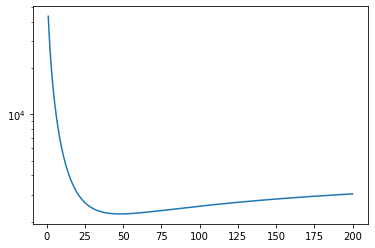

17694.0
[1e-14, 10.0]
1.9993421116565676e-14 29.746846488071654


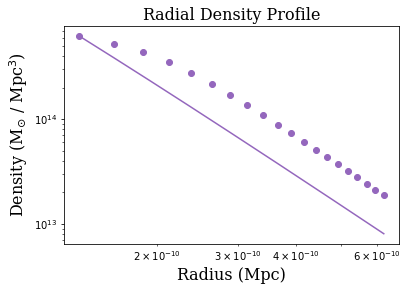

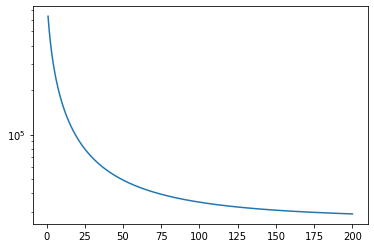

37096.0
[1e-14, 10.0]
9.014492309697721e-14 19.098786937206683


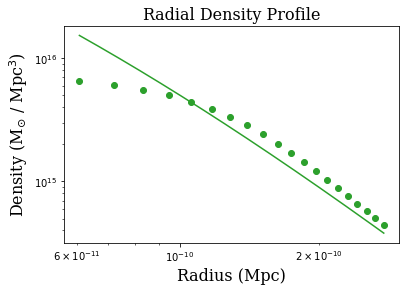

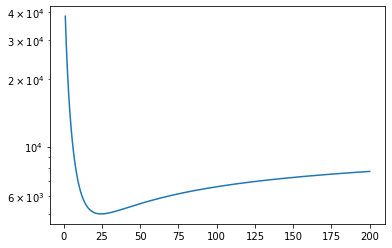

10347.0
[1e-14, 10.0]
1.6010605242739576e-14 7.468987544182782


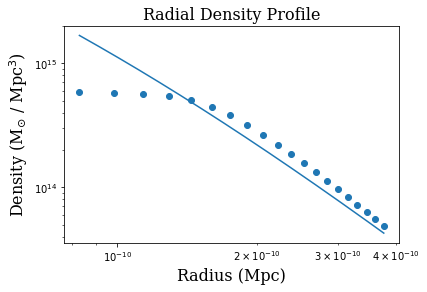

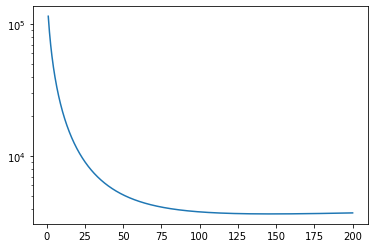

11507.0
[1e-14, 10.0]
1.9941210356375472e-14 18.528686015913223


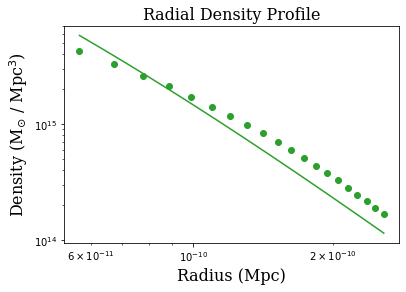

In [9]:
for j in largest_halos[1:5]:
    radial_fractions, density, radial_counts, radius, std_density = get_density_profile(particle_data, ascii_data,
                                                                                       halo_breaks, j, 20)
    plot_likelihood(radial_fractions, radial_counts)
    print(radial_counts[-1])
    #print(radial_counts)
    m200_opt, c200_opt = fit_profile_to_nfw(radial_fractions, radial_counts)
    
    radial_fit = np.linspace(np.min(radial_fractions), np.max(radial_fractions), 1000)
    mass_fit = get_mass(radial_fit, m200_opt, c200_opt)
    density_fit = model_nfw(radial_fit, m200_opt, c200_opt)
    #plot_likelihood(radial_fractions, radial_counts)
    
    plt.plot(radial_fit, density_fit, '-', color=colors[j%5])
    plt.plot(radial_fractions, density, 'o', color=colors[j%5])
    plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
    plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
    plt.title(r'Radial Density Profile',
              fontsize=16, fontname='serif')
    plt.yscale('log')
    plt.xscale('log')
    plt.show();


1.0545500251382604e-15
[1e-14, 10.0]
1.0536443947677811e-15 1.9925861695600187
1.0536443947677811e-15 1.9925861695600187


/sw/arcts/centos7/python3.7-anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in double_scalars
/sw/arcts/centos7/python3.7-anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in log
/sw/arcts/centos7/python3.7-anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in log
/sw/arcts/centos7/python3.7-anaconda/2019.07/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: invalid value encountered in log


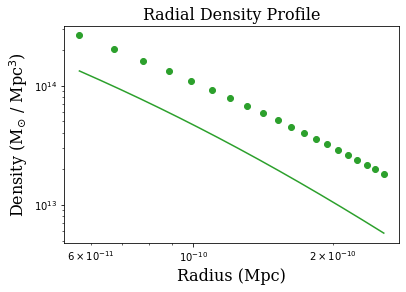

In [177]:
fake_radius = radial_fractions
m200 = MassPerPart * 1000.0
print(m200)
c200 = 2.0
r200 = np.max(fake_radius)
fake_mass = get_mass(fake_radius, m200, c200)
fake_counts = fake_mass / MassPerPart #+ (np.random.random(np.size(fake_radius)) - 1) * 10
fake_volume = (4 / 3) * np.pi * fake_radius**3
fake_density = fake_counts * MassPerPart / fake_volume

m200_opt, c200_opt = fit_profile_to_nfw(radial_fractions, fake_counts)

print(m200_opt, c200_opt)
radial_fit = np.linspace(np.min(fake_radius), np.max(fake_radius), 1000)
nfw_fit = model_nfw(radial_fit, m200_opt, c200_opt)

plt.plot(radial_fit, nfw_fit, '-', color=colors[j%5])
plt.plot(fake_radius, fake_density, 'o', color=colors[j%5])
plt.xlabel('Radius (Mpc)', fontsize=16, fontname='serif')
plt.ylabel(r'Density (M$_{\odot}$ / Mpc$^3$)', fontsize=16, fontname='serif')
plt.title(r'Radial Density Profile',
          fontsize=16, fontname='serif')
plt.xscale('log')
plt.yscale('log')
plt.show()

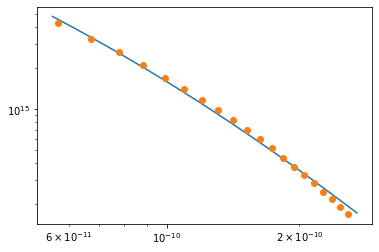

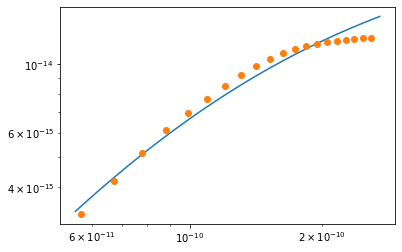

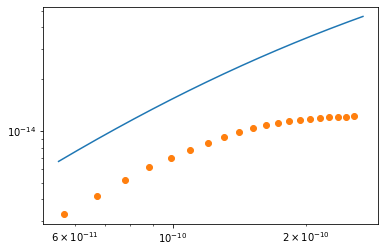

In [186]:
N = 1000
m200 = 1.2e-13
c200 = 10.0
r_vals = np.linspace(5.5e-11, 2.7e-10, N)
densities = model_nfw(r_vals, m200, c200)
masses = get_mass(r_vals, m200, c200)

plt.plot(r_vals, densities, '-')
plt.plot(radial_fractions, density, 'o')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(r_vals, densities * (4 / 3) * np.pi * r_vals**3, '-')
plt.plot(radial_fractions, density * (4 / 3) * np.pi * radial_fractions**3, 'o')
plt.ylabel('Mass from density')
plt.xlabel('Radius')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.plot(r_vals, masses, '-')
plt.plot(radial_fractions, density * (4 / 3) * np.pi * radial_fractions**3, 'o')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [174]:
print(rhoc)

352378606838.5861
